In [1]:
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications.inception_v3 import InceptionV3,  preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.layers import GlobalAvgPool2D
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import label_binarize
from sklearn.metrics import classification_report,confusion_matrix
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping

Using TensorFlow backend.


In [2]:
#DATASET_PATH  = './catsdogs/sample'
#IMAGE_SIZE    = (299, 299)
#NUM_CLASSES   = 2
#BATCH_SIZE    = 8  # try reducing batch size or freeze more layers if your GPU runs out of memory
FREEZE_LAYERS = 2  # freeze the first this many layers for training
#NUM_EPOCHS    = 20
#WEIGHTS_FINAL = 'model-inception_resnet_v2-final.h5'


img_width, img_height = 128,128 # make it bigger

train_data_dir = 'C:/Users/tevin/Collaborations\Habib - Haar - Tevin/Data/Cropped images/Draft1/Train'
test_data_dir = 'C:/Users/tevin/Collaborations\Habib - Haar - Tevin/Data/Cropped images/Draft1/Test'

#Go on a 8:20 spil
#267:67
nb_train_samples = 160
nb_test_samples = 40
epochs = 40
batch_size = 4



#train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
#                                   rotation_range=40,
#                                   width_shift_range=0.2,
#                                   height_shift_range=0.2,
#                                   shear_range=0.2,
#                                   zoom_range=0.2, must be there
#                                   channel_shift_range=10,
#                                   horizontal_flip=True, must be there
#                                   fill_mode='nearest')

#CONSIDER REMOVING PREPROCESS INPUT AND ADDING RESCALE BACK IN relook at hthe data augmentation
train_datagen = ImageDataGenerator(
        #preprocessing_function=preprocess_input,
        rescale=1. / 255,
        #horizontal_flip=True,
        shear_range=0.2, # remoce 
        zoom_range=0.2) 

    # this is the augmentation configuration we will use for testing:
    # only rescaling
test_datagen = ImageDataGenerator(
        #preprocessing_function=preprocess_input,
        rescale=1. / 255,
        #horizontal_flip=True,
        shear_range=0.2,
        zoom_range=0.2)

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        #interpolation='bicubic',
        #shuffle=True,
        class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
        test_data_dir,
        target_size=(img_width, img_height),
        #interpolation='bicubic',
        batch_size=batch_size,
        shuffle=False,
        class_mode='categorical')



Found 160 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


In [3]:


model = tf.keras.applications.InceptionV3(include_top=False, #try and enable
                        weights=None,#'imagenet', 
                        input_tensor=None,
                        input_shape=(img_width, img_height, 3))

#Ask if i am to add the glabal average pooling                          
x = model.output # remove all this
#add the average global layer 
#x = Flatten()(x)
#x = Dropout(0.5)(x)
x = GlobalAveragePooling2D()(x)
#do the global and then follow by a dense layer for binary classification x = Dense(1, activation='softmax')(x)

#x = Dense(2, activation='softmax')(x)
output_layer = Dense(2, activation='softmax', name='softmax')(x)
net_final = Model(inputs=model.input, outputs=output_layer)
#for layer in net_final.layers[:FREEZE_LAYERS]:
#    layer.trainable = False
#for layer in net_final.layers[FREEZE_LAYERS:]:
#    layer.trainable = True

net_final.summary()

# (4) Compile 
net_final.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

filepath="C:/Users/tevin/Collaborations/Habib - Haar - Tevin/Training/weights.InceptionV32.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
    
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=1, mode='auto')

history = net_final.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    validation_data=test_generator,
    validation_steps=nb_test_samples // batch_size,
    epochs=epochs,
    callbacks=[checkpoint,early])


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 63, 63, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 63, 63, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 63, 63, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

Epoch 1/40
40/40 [==============================] - ETA: 0s - loss: 1.3813 - accuracy: 0.4938
Epoch 00001: val_accuracy improved from -inf to 0.50000, saving model to C:/Users/tevin/Collaborations/Habib - Haar - Tevin/Training\weights.InceptionV32.hdf5
40/40 [==============================] - 16s 406ms/step - loss: 1.3813 - accuracy: 0.4938 - val_loss: 0.7745 - val_accuracy: 0.5000
Epoch 2/40
40/40 [==============================] - ETA: 0s - loss: 0.8521 - accuracy: 0.5688
Epoch 00002: val_accuracy did not improve from 0.50000
40/40 [==============================] - 13s 326ms/step - loss: 0.8521 - accuracy: 0.5688 - val_loss: 2.3109 - val_accuracy: 0.5000
Epoch 3/40
40/40 [==============================] - ETA: 0s - loss: 0.7326 - accuracy: 0.6750
Epoch 00003: val_accuracy did not improve from 0.50000
40/40 [==============================] - 14s 346ms/step - loss: 0.7326 - accuracy: 0.6750 - val_loss: 0.7578 - val_accuracy: 0.5000
Epoch 4/40
40/40 [==============================] - E

Epoch 28/40
40/40 [==============================] - ETA: 0s - loss: 0.2608 - accuracy: 0.9000
Epoch 00028: val_accuracy did not improve from 0.97500
40/40 [==============================] - 17s 422ms/step - loss: 0.2608 - accuracy: 0.9000 - val_loss: 0.9792 - val_accuracy: 0.6750
Epoch 29/40
40/40 [==============================] - ETA: 0s - loss: 0.3212 - accuracy: 0.8813
Epoch 00029: val_accuracy did not improve from 0.97500
40/40 [==============================] - 16s 402ms/step - loss: 0.3212 - accuracy: 0.8813 - val_loss: 2.2906 - val_accuracy: 0.5000
Epoch 30/40
40/40 [==============================] - ETA: 0s - loss: 0.7057 - accuracy: 0.6313
Epoch 00030: val_accuracy did not improve from 0.97500
40/40 [==============================] - 18s 460ms/step - loss: 0.7057 - accuracy: 0.6313 - val_loss: 1.0638 - val_accuracy: 0.5250
Epoch 31/40
40/40 [==============================] - ETA: 0s - loss: 0.6375 - accuracy: 0.6313
Epoch 00031: val_accuracy did not improve from 0.97500
40/4

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
[0.4937500059604645, 0.5687500238418579, 0.675000011920929, 0.6875, 0.8125, 0.71875, 0.831250011920929, 0.8187500238418579, 0.8374999761581421, 0.856249988079071, 0.8374999761581421, 0.78125, 0.8812500238418579, 0.887499988079071, 0.9125000238418579, 0.925000011920929, 0.9312499761581421, 0.893750011920929, 0.731249988079071, 0.831250011920929, 0.9437500238418579, 0.8812500238418579, 0.9375, 0.8687499761581421, 0.8999999761581421, 0.9750000238418579, 0.8999999761581421, 0.8999999761581421, 0.8812500238418579, 0.6312500238418579, 0.6312500238418579, 0.856249988079071, 0.8687499761581421, 0.9125000238418579, 0.9312499761581421, 0.96875, 0.8999999761581421, 0.8999999761581421, 0.78125, 0.8812500238418579]


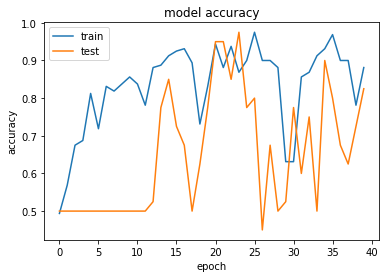

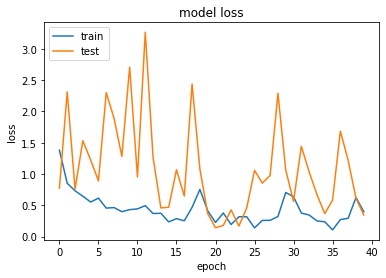

In [8]:
# list all data in history
#plt.figure(figsize=(15,8))

print(history.history.keys())
print(history.history['accuracy'])

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('C:/Users/tevin/Collaborations/Habib - Haar - Tevin/Results/InceptionV3/Accuracy2.png')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('C:/Users/tevin/Collaborations/Habib - Haar - Tevin/Results/InceptionV3/Loss2.png')
plt.show()

#loss, acc = model.evaluate_generator(test_generator, nb_test_samples // batch_size+1)
#print(acc * 100)
#print(loss * 100)

#take off shuiffle

In [14]:
from tensorflow import keras
from keras.models import load_model


model = keras.models.load_model('C:/Users/tevin/Collaborations/Habib - Haar - Tevin/Training/weights.InceptionV32.hdf5')

#model.load_weights("C:/Users/tevin/Collaborations/Habib - Haar - Tevin/Training/weights.Inception.hdf5")
# Compile model (required to make predictions)
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

print("Created model and loaded weights from file")


loss, accuracy = model.evaluate_generator(test_generator, nb_test_samples // batch_size+1, verbose=0)
print(accuracy)
print(loss)

Created model and loaded weights from file
0.9750000238418579
0.16159233450889587


Instructions for updating:
Please use Model.predict, which supports generators.
[[0.88487446 0.1151256 ]
 [0.9945857  0.00541436]
 [0.36503205 0.634968  ]
 [0.8361849  0.16381511]
 [0.95499486 0.04500517]
 [0.8264827  0.17351732]
 [0.99581426 0.0041857 ]
 [0.9921713  0.00782868]
 [0.98482805 0.01517196]
 [0.9740208  0.02597926]
 [0.9960294  0.00397067]
 [0.504337   0.495663  ]
 [0.9891963  0.01080376]
 [0.99687827 0.00312175]
 [0.85917354 0.1408264 ]
 [0.933562   0.06643799]
 [0.99717724 0.00282274]
 [0.8021086  0.19789144]
 [0.8626902  0.1373098 ]
 [0.9968471  0.00315285]
 [0.01891669 0.98108333]
 [0.04496231 0.9550377 ]
 [0.23530982 0.76469016]
 [0.1916101  0.8083899 ]
 [0.24113764 0.7588624 ]
 [0.02784595 0.972154  ]
 [0.01111177 0.9888882 ]
 [0.2605972  0.73940283]
 [0.02466077 0.97533923]
 [0.20933563 0.79066443]
 [0.23158088 0.768419  ]
 [0.04701308 0.9529869 ]
 [0.10485679 0.8951432 ]
 [0.10409663 0.8959034 ]
 [0.11593666 0.8840633 ]
 [0.2747541  0.7252459 ]
 [0.01275963 0.98724

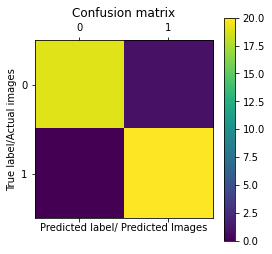

In [10]:
preds3 = model.predict_generator(test_generator, nb_test_samples // batch_size)
#print(test_generator.classes.shape)
#print(np.shape(preds3))
print(preds3)
prediction2 = np.argmax(preds3, axis=1)

print(preds3)

print('this is the predicted data')
print(prediction2)
print('this is the test data')
print(test_generator.classes)

print('Confusion Matrix')
cm = confusion_matrix(test_generator.classes, prediction2)
print(cm)


print('Classification Report')
#target_names = ['Noise','Strokes']
print(classification_report(test_generator.classes, prediction2))

plt.matshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label/Actual images')
plt.xlabel('Predicted label/ Predicted Images')
plt.savefig('C:/Users/tevin/Collaborations/Habib - Haar - Tevin/Results/InceptionV3/Confusion2.png')
plt.show()